## Notebook for imaging eMERLIN calibrated data

This illustrates how RASCIL may be used to image eMERLIN data. The example data is from:

http://www.e-merlin.ac.uk/distribute/support/tutorials/3C277.1_20150505.tar

For a summary of the images produced by the eMERLIN CASA pipeline see:

 http://www.e-merlin.ac.uk/distribute/support/tutorials/3C277.1_20150505/weblog/index.html
 
 To run this notebook, you will need:
 
 - RASCIL from https://github.com/SKA-ScienceDataProcessor/rascil
 - The data from above
 - nifty-gridder from https://gitlab.mpcdf.mpg.de/ift/nifty_gridder
 

In [1]:
%matplotlib inline

import logging
import os

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['image.cmap'] = 'rainbow'

import numpy

from rascil.processing_components import show_image, qa_image, export_image_to_fits, qa_gaintable, \
    create_blockvisibility_from_ms, list_ms, integrate_visibility_by_channel, \
    concatenate_blockvisibility_frequency, plot_uvcoverage, plot_visibility, convert_blockvisibility_to_stokesI, \
    convert_blockvisibility_to_visibility, convert_visibility_to_blockvisibility, weight_visibility,\
    create_image_from_visibility, advise_wide_field, create_calibration_controls, gaintable_plot

from rascil.processing_components.imaging.ng import invert_ng


cwd = os.getcwd()

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.FileHandler('%s/eMERLIN_imaging.log' % cwd))

logging.basicConfig(filename='%s/eMERLIN_imaging.log' % cwd,
                    filemode='w',
                    format='%(date)s %(asctime)s.%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)
log.info("Logging to %s/eMERLIN_imaging.log" % cwd)


#### List the contents of the MeasurementSet: sources and data descriptors

In [2]:
print(list_ms('../../data/3C277.1_avg.ms'))

(['1302+5748', '0319+415', '1407+284', '1252+5634', '1331+305'], [0, 1, 2, 3])


#### Load just 3C277.1 (1252+5634) and '1302+5748'

In [3]:
selected_sources = ['1302+5748', '1252+5634']
bvis_list = create_blockvisibility_from_ms('../../data/3C277.1_avg.ms', datacolumn='CORRECTED_DATA',
                                           selected_sources=selected_sources)
sources = numpy.unique([bv.source for bv in bvis_list])
print(sources)

['1252+5634' '1302+5748']


#### Average across all each BlockVisibility over all 128 channels, and then concatenate into single BlockVisibilitys, one per source

In [4]:
avis_list = [integrate_visibility_by_channel(bvis) for bvis in bvis_list]
blockvis = [concatenate_blockvisibility_frequency(avis_list[isource * 4:(isource * 4 + 4)])
            for isource, source in enumerate(sources)]

#### Plot the uv coverage and visibility

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.cmap'] = 'rainbow'

for svis in blockvis:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plot_uvcoverage([svis], ax=ax[0], title='UV Coverage {source:s}'.format(source=svis.source))
    plot_visibility([svis], ax=ax[1], title='Visibility amplitude {source:s}'.format(source=svis.source))
    plt.tight_layout()
    plt.show(block=False)
    

#### Run one of:
- Invert + deconvolve + restore (mode='invert')
- Continuum Imaging Pipeline (mode='cip')
- ICAL pipeline (mode='ical')



Processing 1302+5748 via cip pipeline


Quality assessment:
	Origin: qa_image
	Context: Deconvolved image
	Data:
		shape: '(1, 1, 1024, 1024)'
		max: '0.06859842068084986'
		min: '-0.0037341681416415257'
		maxabs: '0.06859842068084986'
		rms: '9.966637354990386e-05'
		sum: '0.38285452179073837'
		medianabs: '0.0'
		medianabsdevmedian: '0.0'
		median: '0.0'

Quality assessment:
	Origin: qa_image
	Context: Residual image
	Data:
		shape: '(1, 1, 1024, 1024)'
		max: '0.002134924616845894'
		min: '-0.0021643151883895774'
		maxabs: '0.0021643151883895774'
		rms: '0.0005280612571509019'
		sum: '0.25587501000331825'
		medianabs: '0.0003625399519369096'
		medianabsdevmedian: '0.00036258532802584'
		median: '1.8581314531230994e-06'

Quality assessment:
	Origin: qa_image
	Context: Restored image
	Data:
		shape: '(1, 1, 1024, 1024)'
		max: '0.37633098490174355'
		min: '-0.003046156206398651'
		maxabs: '0.37633098490174355'
		rms: '0.0023600896676097558'
		sum: '29.253950118888923'
		medianabs: '

<Figure size 864x864 with 0 Axes>

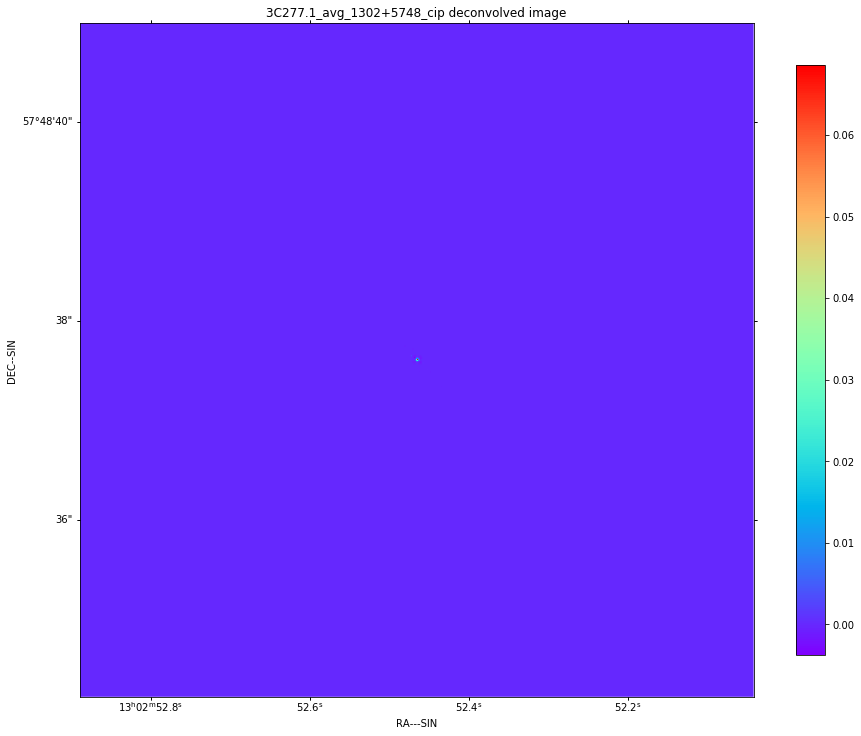

<Figure size 864x864 with 0 Axes>

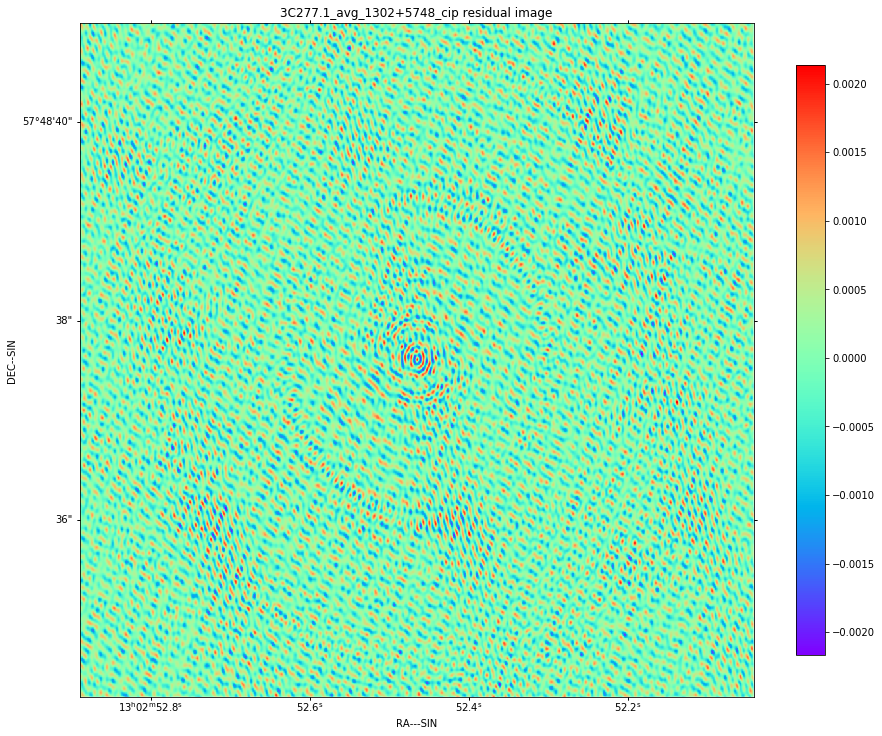

<Figure size 864x864 with 0 Axes>

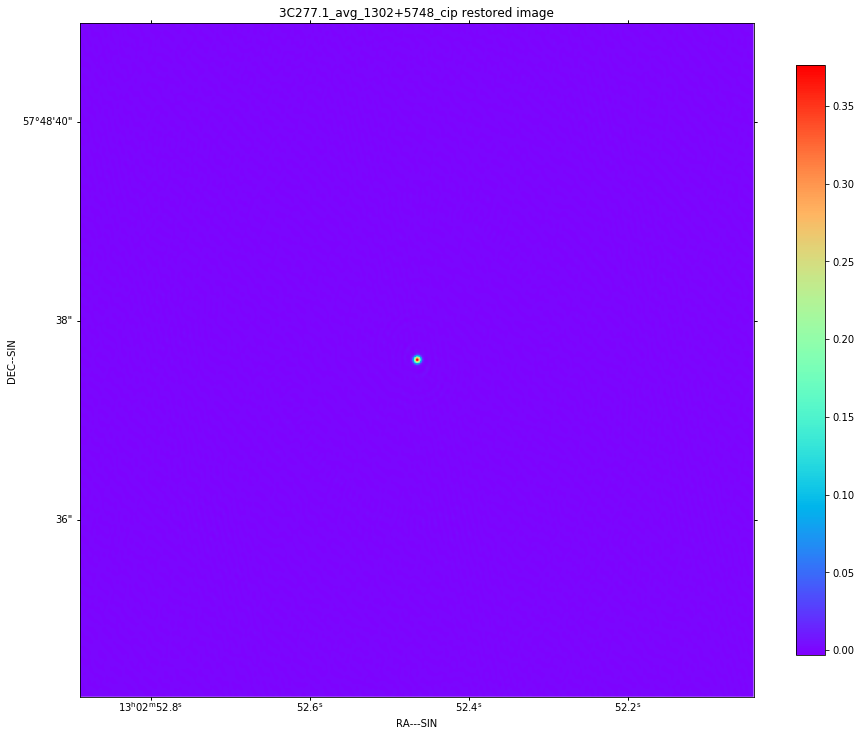

<Figure size 864x864 with 0 Axes>

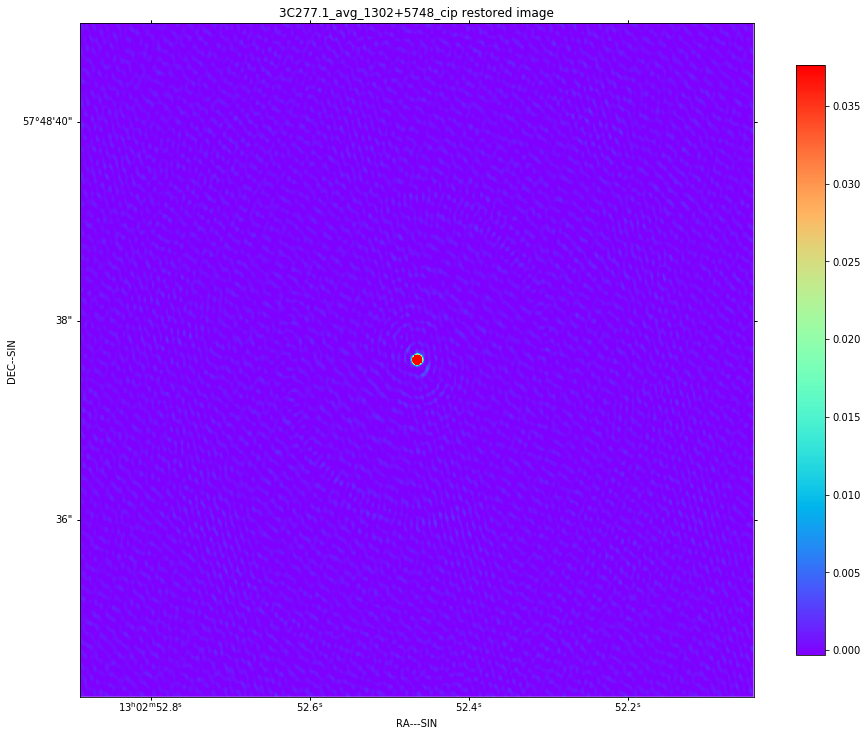

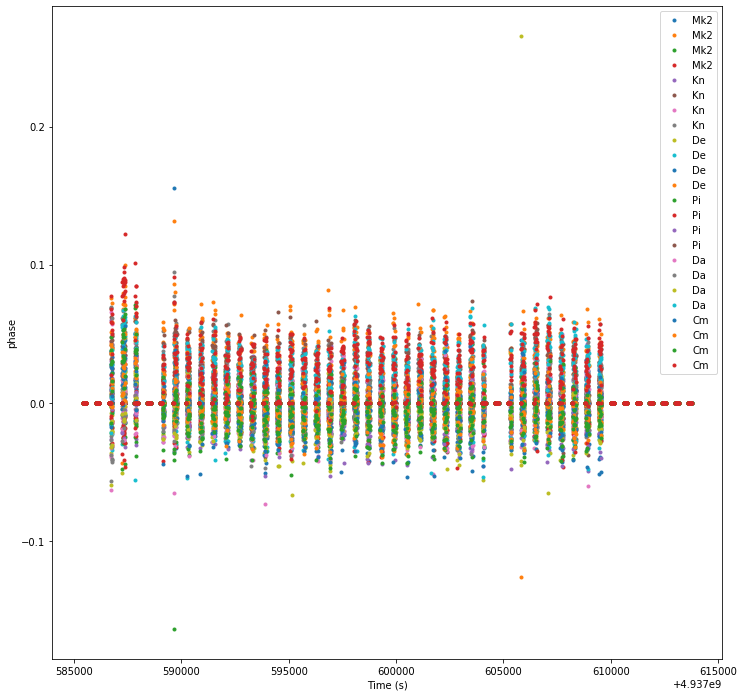

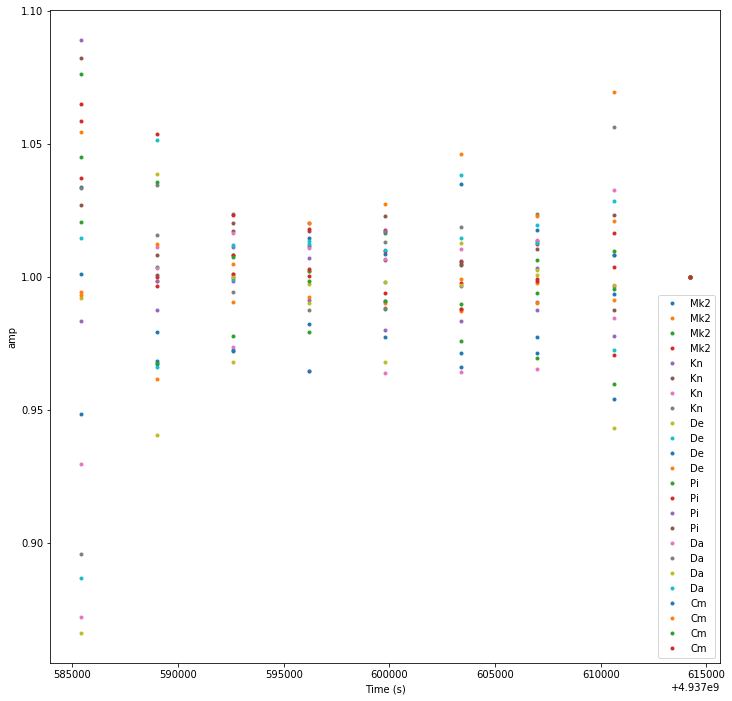

<Figure size 864x864 with 0 Axes>

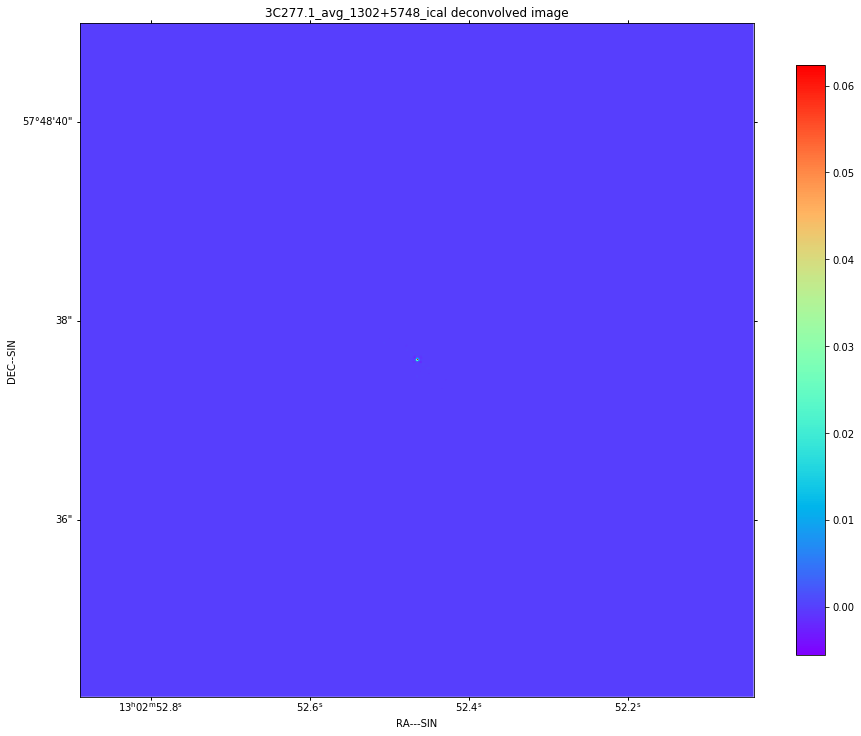

<Figure size 864x864 with 0 Axes>

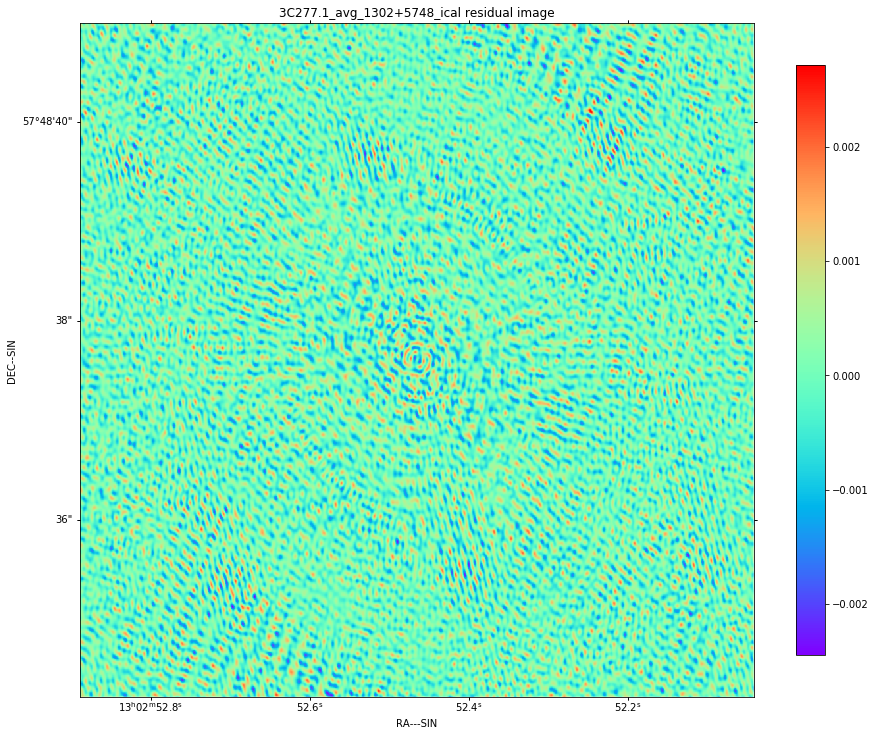

<Figure size 864x864 with 0 Axes>

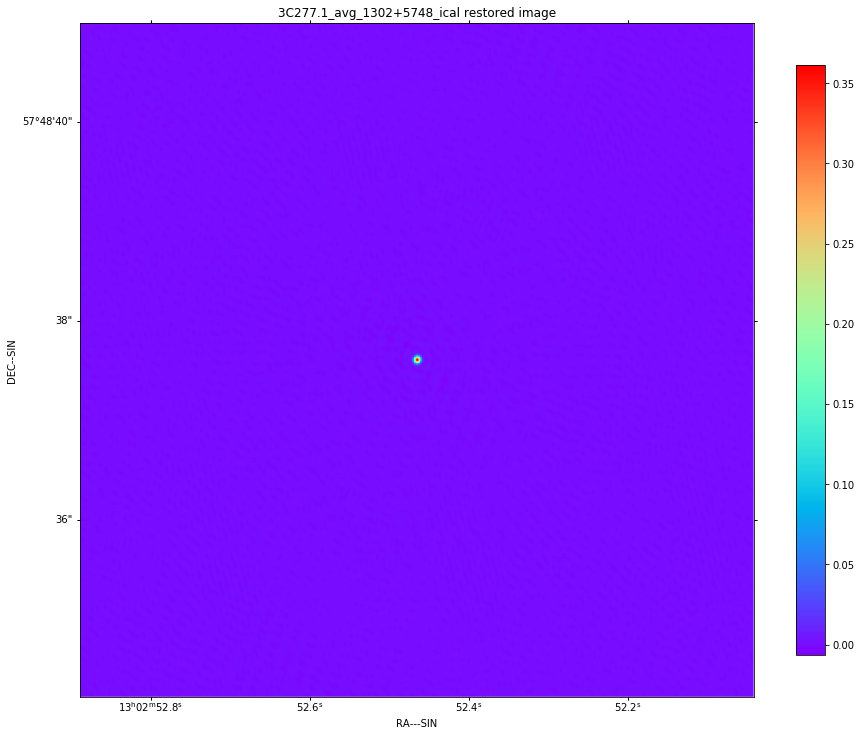

<Figure size 864x864 with 0 Axes>

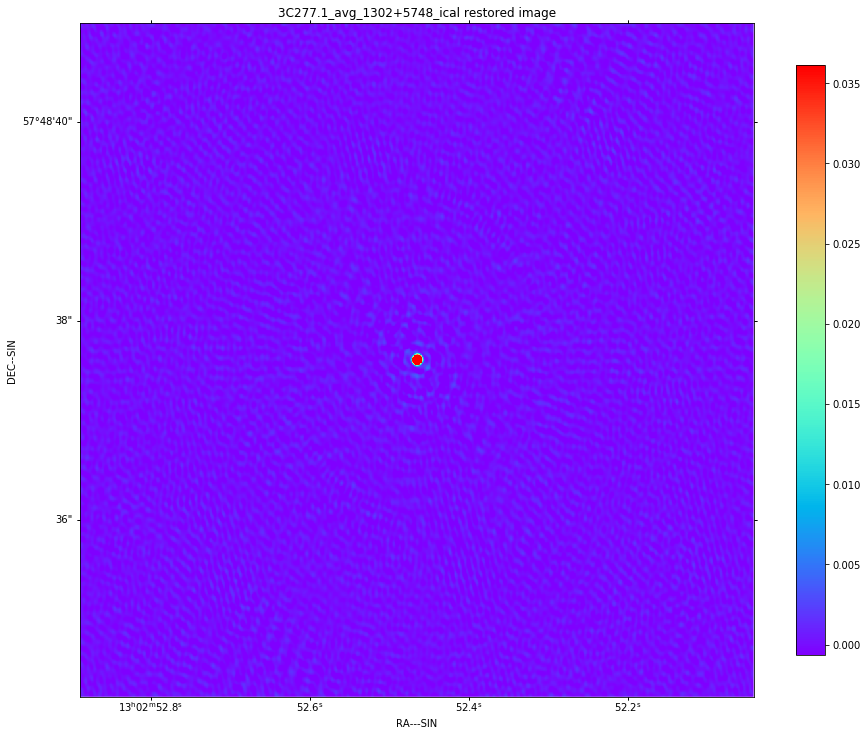

<Figure size 864x864 with 0 Axes>

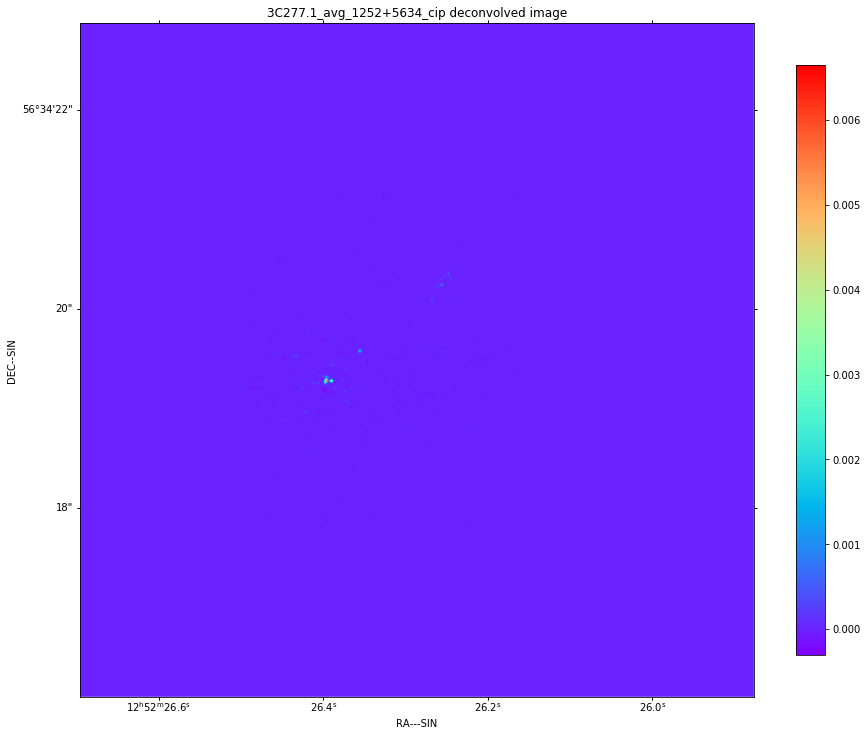

<Figure size 864x864 with 0 Axes>

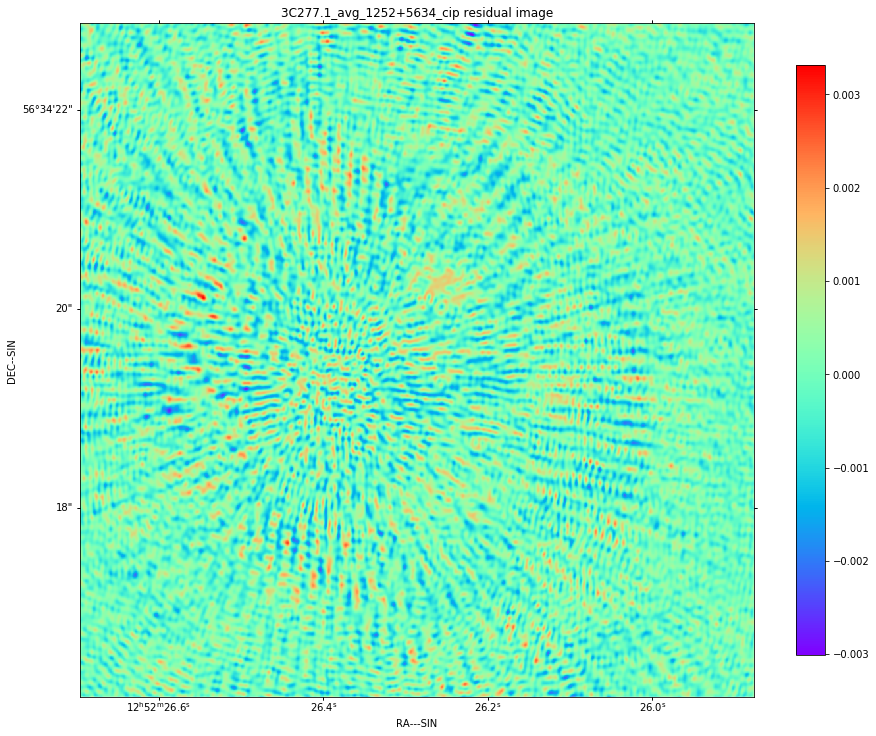

<Figure size 864x864 with 0 Axes>

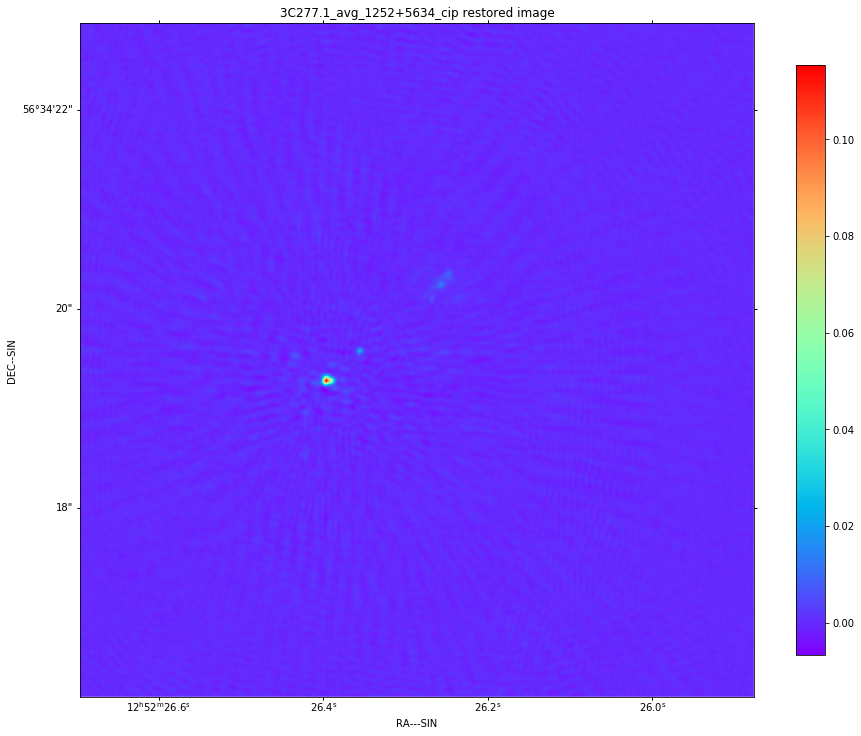

<Figure size 864x864 with 0 Axes>

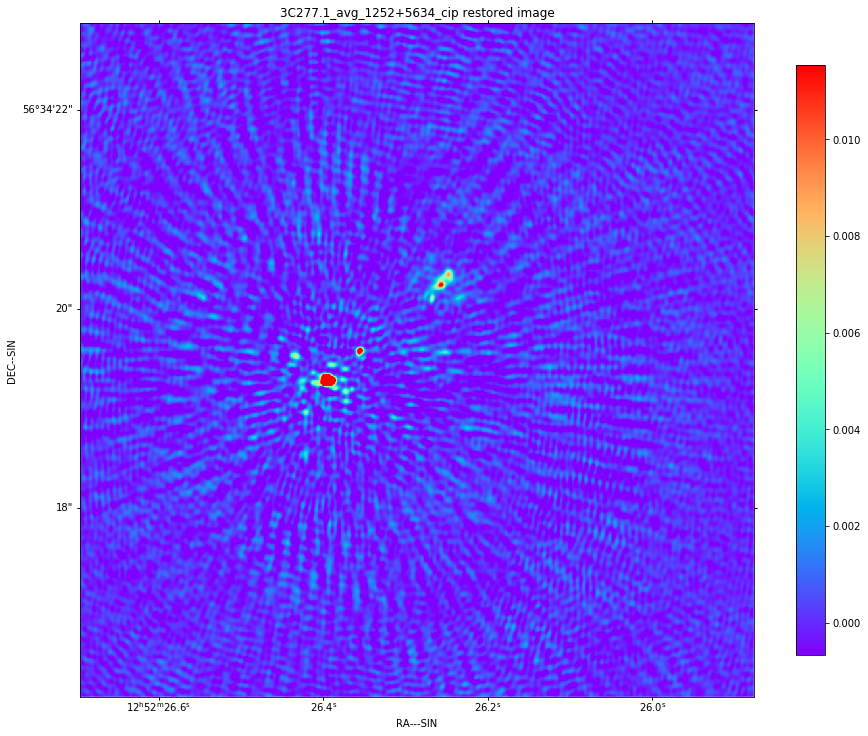

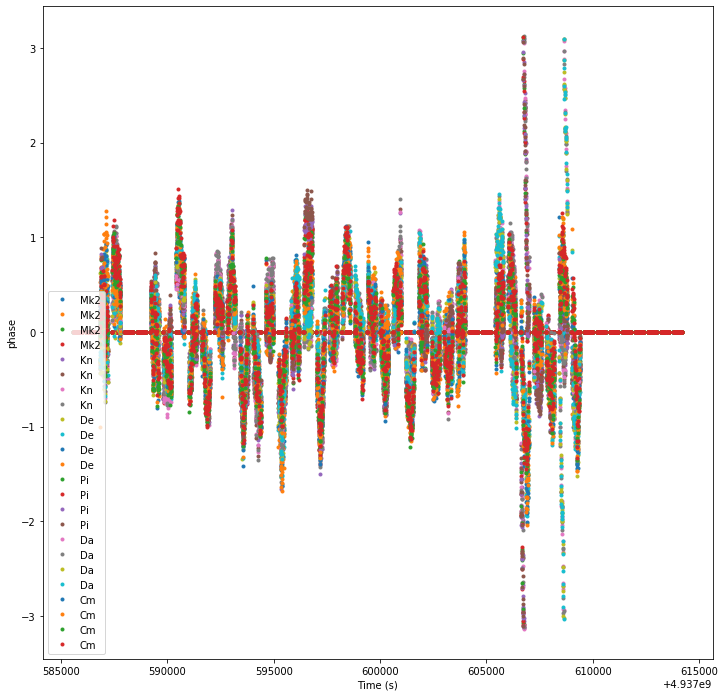

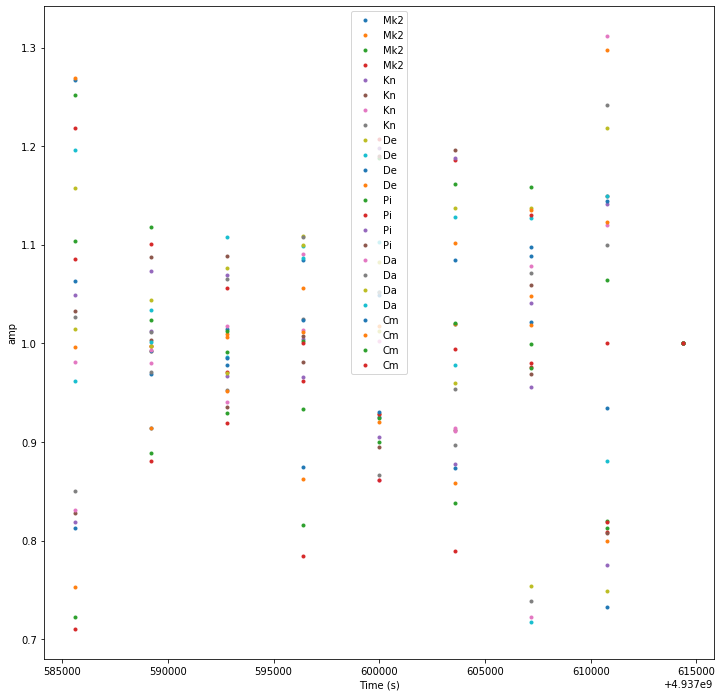

<Figure size 864x864 with 0 Axes>

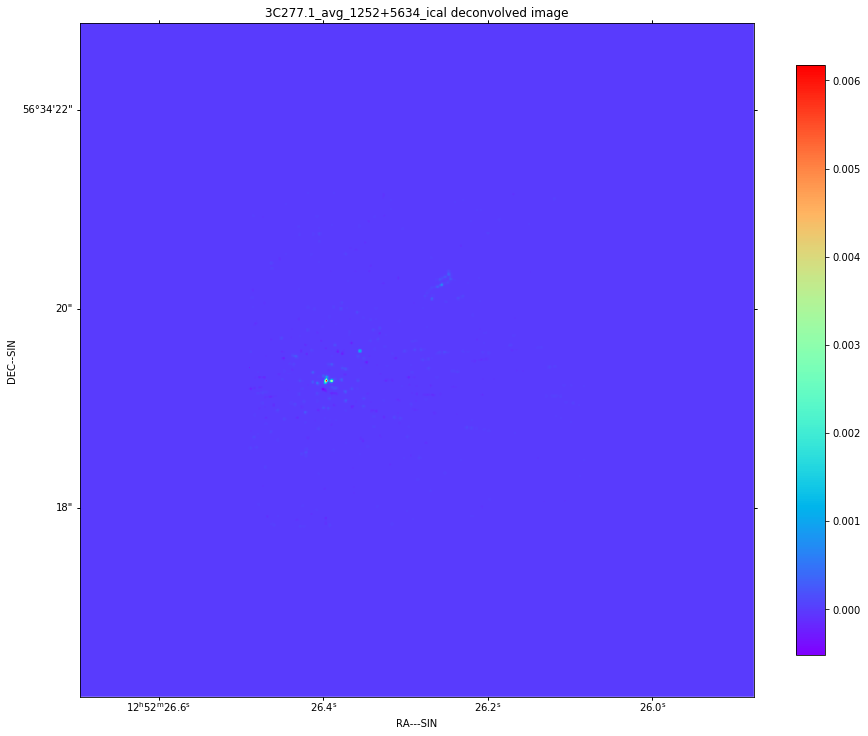

<Figure size 864x864 with 0 Axes>

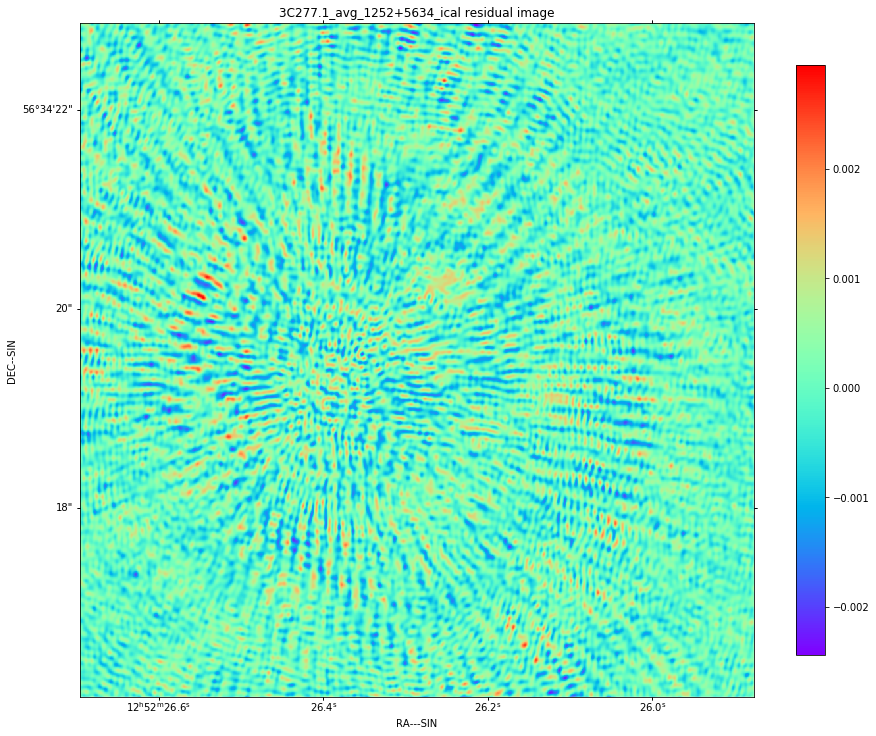

<Figure size 864x864 with 0 Axes>

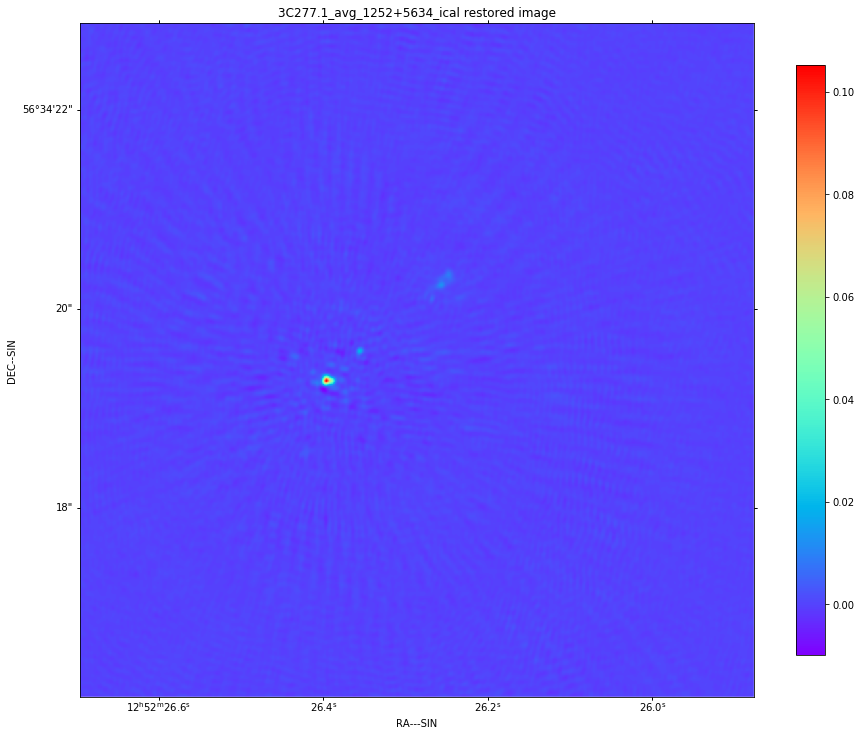

<Figure size 864x864 with 0 Axes>

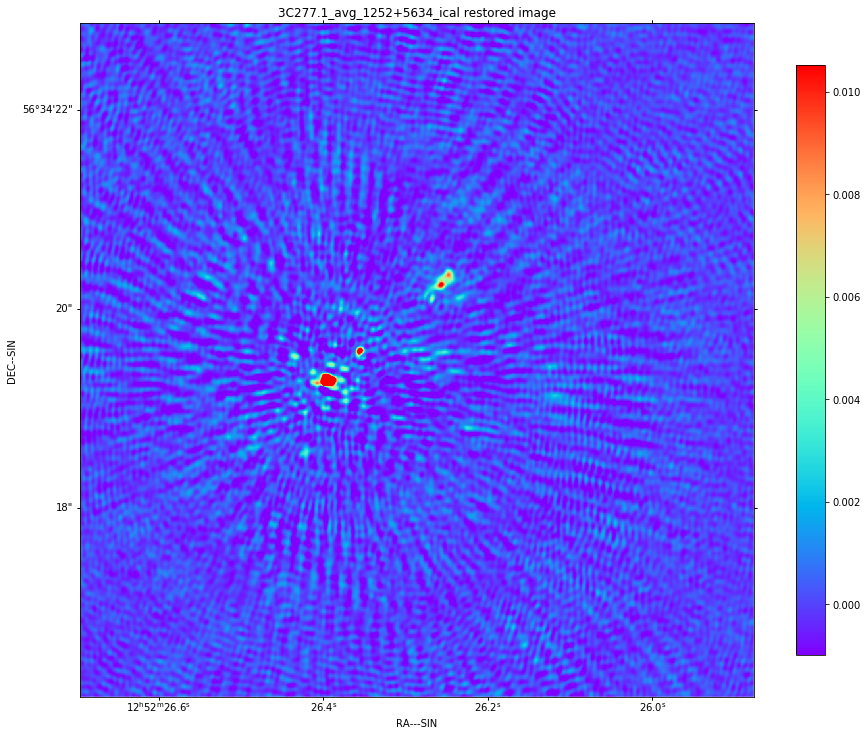

In [5]:
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['image.cmap'] = 'rainbow'

from rascil.workflows import continuum_imaging_list_serial_workflow, ical_list_serial_workflow

advice = advise_wide_field(avis_list[0], verbose=False)
for svis in blockvis:
    frequency = [numpy.mean(svis.frequency)]
    channel_bandwidth = [numpy.sum(svis.channel_bandwidth)]
    ivis = convert_blockvisibility_to_stokesI(svis)
    model = create_image_from_visibility(ivis, npixel=1024, cellsize=advice['cellsize']/3.0, nchan=1,
                                         frequency=frequency, channel_bandwidth=channel_bandwidth)
    cvis = convert_blockvisibility_to_visibility(ivis)
    cvis = weight_visibility(cvis, model)
    ivis = convert_visibility_to_blockvisibility(cvis)
    
    for mode in ["cip", "ical"]:
        
        print("\n")
        print("Processing {source:s} via {mode:s} pipeline".format(source=svis.source, mode=mode))
        print("\n")

        filename_root = "3C277.1_avg_{source:s}_{mode:s}".format(source=svis.source, mode=mode)

        if mode == "ical":
            controls = create_calibration_controls()
            controls['T']['first_selfcal'] = 1
            controls['T']['phase_only'] = True
            controls['T']['timeslice'] = 3.0
            controls['G']['first_selfcal'] = 10
            controls['G']['phase_only'] = False
            controls['G']['timeslice'] = 3600.0


            deconvolved, residual, restored, gt_list = ical_list_serial_workflow([ivis], [model],
                                                                                 context='ng',
                                                                                 nmajor=15,
                                                                                 niter=1000, algorithm='msclean',
                                                                                 scales=[0, 3, 10], gain=0.1,
                                                                                 fractional_threshold=0.5,
                                                                                 threshold=0.0015,
                                                                                 window_shape='quarter',
                                                                                 do_wstacking=False,
                                                                                 global_solution=False,
                                                                                 calibration_context='TG',
                                                                                 do_selfcal=True,
                                                                                 controls=controls)
            deconvolved = deconvolved[0]
            residual = residual[0][0]
            restored = restored[0]
            gt = gt_list[0]['T']
            print(qa_gaintable(gt))
            fig, ax = plt.subplots(1,1)
            gaintable_plot(gt, ax, value='phase')
            plt.show(block=False)

            gt = gt_list[0]['G']
            print(qa_gaintable(gt))
            fig, ax = plt.subplots(1,1)
            gaintable_plot(gt, ax, value='amp')
            plt.show(block=False)


        elif mode == "cip":
            deconvolved, residual, restored = continuum_imaging_list_serial_workflow([ivis], [model], context='ng',
                                                                                     nmajor=10,
                                                                                     niter=1000, algorithm='msclean',
                                                                                     scales=[0, 3, 10], gain=0.1,
                                                                                     fractional_threshold=0.5,
                                                                                     threshold=0.0015,
                                                                                     window_shape='quarter',
                                                                                     do_wstacking=False)

            deconvolved = deconvolved[0]
            residual = residual[0][0]
            restored = restored[0]

        else:
            mode = "invert"
            dirty, sumwt = invert_ng(ivis, model, do_wstacking=False)
            print(sumwt)
            plt.clf()
            show_image(dirty, title=svis.source + " Dirty image", cm="rainbow")
            plt.show(block=False)

            psf, sumwt = invert_ng(ivis, model, do_wstacking=False, dopsf=True)
            plt.clf()
            show_image(psf, title=svis.source + " PSF", cm="rainbow")
            plt.show(block=False)

            from processing_components.image.deconvolution import deconvolve_cube, restore_cube

            deconvolved, residual = deconvolve_cube(dirty, psf, niter=1000, algorithm='msclean',
                                                    fractional_threshold=0.5,
                                                    scales=[0, 3, 10], gain=0.1, threshold=0.003,
                                                    window_shape='quarter')
            restored = restore_cube(deconvolved, psf, residual)

        print(qa_image(deconvolved, context='Deconvolved image'))
        plt.clf()
        show_image(deconvolved, title=filename_root + " deconvolved image", cm="rainbow")
        plt.tight_layout()
        plt.show(block=False)
        filename = "{root:s}_deconvolved.fits".format(root=filename_root)
        export_image_to_fits(deconvolved, filename)


        print(qa_image(residual, context='Residual image'))
        plt.clf()
        show_image(residual, title=filename_root + " residual image", cm="rainbow")
        plt.tight_layout()
        plt.show(block=False)
        filename = "{root:s}_residual.fits".format(root=filename_root)
        export_image_to_fits(residual, filename)


        print(qa_image(restored, context='Restored image'))
        plt.clf()
        show_image(restored, title=filename_root + " restored image", cm="rainbow")
        plt.tight_layout()
        plt.show(block=False)        

        plt.clf()
        show_image(restored, title=filename_root + " restored image", vscale=0.1, cm="rainbow")
        plt.tight_layout()
        plt.show(block=False)        

        filename = "{root:s}_restored.fits".format(root=filename_root)
        export_image_to_fits(restored, filename)
    